Heavy lift from https://botorch.org/tutorials/closed_loop_botorch_only

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from typing import Optional

import torch

from botorch.models.transforms.input import Normalize
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.objective import GenericMCObjective
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from sklearn.manifold import TSNE

from gpytorch.kernels import MaternKernel

import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.acquisition import (
    qLogExpectedImprovement,
    qLogNoisyExpectedImprovement,
    qUpperConfidenceBound
)
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler

import json
import pandas as pd

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

import matplotlib.pyplot as plt

import sys
sys.path.append('/home/ubuntu/Code/silica-np-synthesis/')
from sample_utilities import samples
import numpy as np

In [4]:
## Load existing data

In [3]:
with open('constants_Round2_2025_01_28.json', 'rt') as f:
    synth_constants = json.load(f) 

In [4]:
bounds = {}
for reactant, consts in synth_constants.items():
    bound = (consts['minimum_volume_fraction'], consts['maximum_volume_fraction'])
    bounds[reactant] = bound

In [5]:
synth_data = pd.read_csv('synth_table_Round2Random_80nm.csv')
synth_data = synth_data[~synth_data['ap_distance'].isna()]
#synth_data = synth_data[synth_data['ap_distance'] < 8]

In [6]:
synth_data

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,well,campaign,target_volume,teos_vol_frac,ammonia_vol_frac,water_vol_frac,ethanol_vol_frac,ap_distance,rmse_distance,experiment_status,rank
0,c563cb4d-d727-437f-9a6a-fef3eccbbe50,222.617091,399.058218,590.750129,487.574561,0.485800,12.367236,0.014890,A1,Round2Random,1700.0,0.045948,0.082365,0.121930,0.286809,1.522190,0.255116,complete,17.0
1,3ef8b92f-f2eb-4134-ad6c-ae3329408457,424.578425,225.592744,374.598586,675.230244,0.254717,23.586966,0.028651,A2,Round2Random,1700.0,0.087632,0.046562,0.077317,0.397194,1.548249,0.264217,complete,25.0
2,0507cf19-673b-4d6b-922e-c21f718ad4fe,290.225034,259.039405,534.588398,616.147162,0.372633,16.123118,0.019498,A3,Round2Random,1700.0,0.059902,0.053465,0.110338,0.362440,1.489590,0.254219,complete,12.0
3,82fc5e1c-5d6e-4ecd-82c3-eb912535a0d7,87.221241,134.097491,46.585717,1432.095551,1.239920,4.845476,0.006080,A4,Round2Random,1700.0,0.018002,0.027678,0.009615,0.842409,0.991199,0.298204,complete,1.0
4,9964ab9f-5b01-4ae2-b492-a1be55ce083f,44.198312,353.311589,274.447630,1028.042468,2.446865,2.455386,0.003029,A5,Round2Random,1700.0,0.009122,0.072923,0.056646,0.604731,1.429035,0.302280,complete,7.0
5,d263a9a8-70c2-49a4-badb-03a72fa16632,362.014946,39.599052,668.974648,629.411354,0.298737,20.111324,0.024235,A6,Round2Random,1700.0,0.074719,0.008173,0.138075,0.370242,1.506382,0.314632,complete,15.0
6,586ae478-4dab-4d7d-9382-ab359a49387a,467.857264,437.608025,146.758782,647.775928,0.231155,25.991272,0.031714,A7,Round2Random,1700.0,0.096565,0.090322,0.030291,0.381045,1.886809,1.358506,complete,31.5
7,7386215f-7150-48a6-b35f-96cbe5b743cf,150.571271,186.816687,456.385989,906.226053,0.718247,8.364814,0.010229,A8,Round2Random,1700.0,0.031078,0.038559,0.094197,0.533074,1.536987,0.259520,complete,21.0
8,d408858a-bbae-4227-8e64-6c368a1f3398,171.120992,296.220804,158.477050,1074.181154,0.631993,9.506430,0.011766,B1,Round2Random,1700.0,0.035319,0.061139,0.032709,0.631871,1.533968,0.256223,complete,20.0
9,0c042bd5-e5ed-4460-9bb9-d8556dba293c,429.271862,97.506840,378.830708,794.390591,0.251932,23.847704,0.029060,B3,Round2Random,1700.0,0.088601,0.020125,0.078190,0.467289,1.560358,0.258701,complete,28.0


In [7]:
x_data = synth_data[['teos_vol_frac', 'ammonia_vol_frac', 'water_vol_frac']]
y_data = - synth_data['rmse_distance']

In [8]:
y_data.min()

-1.3585063430102955

## data pre-processing

In [9]:
y_data_norm = normalize(torch.tensor(y_data.to_numpy()), torch.tensor([[y_data.min()], [y_data.max()]])).reshape(-1,1)

In [10]:
bounds_torch_norm = torch.tensor([bounds['TEOS'], bounds['ammonia'], bounds['water']]).transpose(-1, -2)

In [11]:
bounds_torch_opt = torch.tensor([[0, 0, 0], [1.0, 1.0, 1.0]], dtype = torch.float32)

In [12]:
x_data_torch = torch.tensor(x_data.to_numpy())

In [13]:
x_data_norm = normalize(x_data_torch, bounds_torch_norm)

## Visualize design space

In [14]:
## Concentrations

In [15]:
x_data_norm[:,0]

tensor([0.4310, 0.8698, 0.5779, 0.1369, 0.0434, 0.7339, 0.9638, 0.2745, 0.3191,
        0.8800, 0.6722, 0.1130, 0.2070, 0.5157, 0.7865, 0.4751, 0.4552, 0.7674,
        0.5359, 0.2259, 0.0694, 0.6298, 0.9234, 0.3617, 0.2947, 0.9827, 0.7140,
        0.0242, 0.1802, 0.6205, 0.8263, 0.3886], dtype=torch.float64)

In [16]:
best_10_ind = torch.argsort(y_data_norm, dim = 0, descending = True)[0:10].reshape(-1)

In [17]:
best_10_ind

tensor([17,  2, 26,  0, 23, 21,  8, 16,  9,  7])

In [18]:
X_best10 = x_data_norm[best_10_ind,:]

In [19]:
X_best10.shape

torch.Size([10, 3])

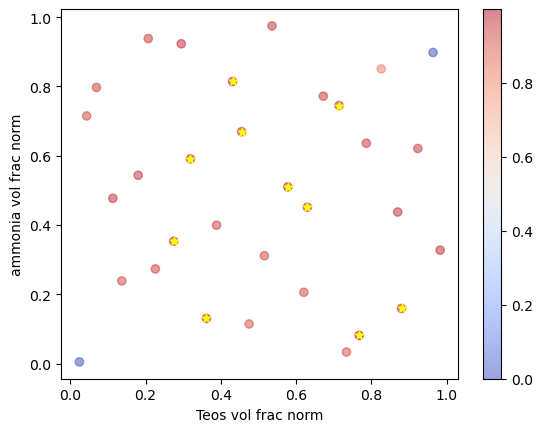

In [20]:
fig, ax = plt.subplots()

sc = ax.scatter(x_data_norm[:,0], x_data_norm[:,1], c = y_data_norm, cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac norm')
ax.set_ylabel('ammonia vol frac norm')


ax.scatter(X_best10[:,0], X_best10[:,1], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

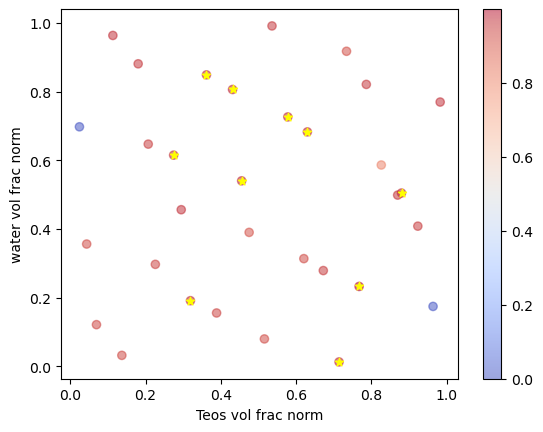

In [21]:
fig, ax = plt.subplots()

sc = ax.scatter(x_data_norm[:,0], x_data_norm[:,2], c = y_data_norm, cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac norm')
ax.set_ylabel('water vol frac norm')


ax.scatter(X_best10[:,0], X_best10[:,2], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

In [22]:
### TSNE rep

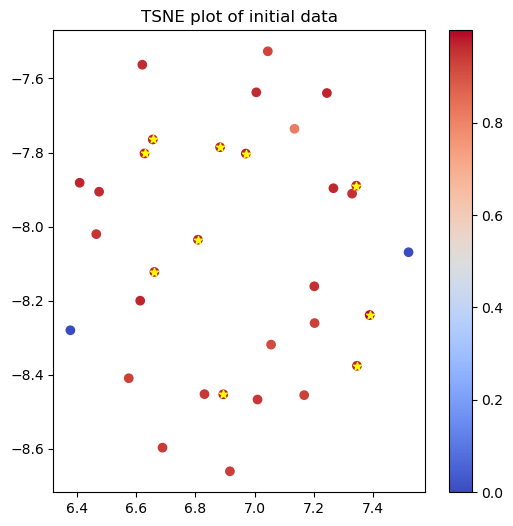

In [23]:

tsne = TSNE()

x_tsne_og = tsne.fit_transform(x_data_norm)

x_tsne_bestn = x_tsne_og[best_10_ind,:]

fig, ax = plt.subplots(figsize = (6,6))

sc = ax.scatter(x_tsne_og[:,0][:len(x_data_norm)], x_tsne_og[:,1][:len(x_data_norm)], c = y_data_norm, cmap = plt.cm.coolwarm)

ax.scatter(x_tsne_bestn[:,0], x_tsne_bestn[:,1], marker = '*', c = 'yellow')
ax.set_title("TSNE plot of initial data")
fig.colorbar(sc, ax = ax)

## Set up BO things

In [24]:
#bounds = torch.tensor([[0.0] * 3, [1.0] * 3], device=device, dtype=dtype)

BATCH_SIZE = 10  if not SMOKE_TEST else 2
NUM_RESTARTS = 50 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32

N_TRIALS = 3 if not SMOKE_TEST else 2
N_BATCH = 10 if not SMOKE_TEST else 2
MC_SAMPLES = 512 if not SMOKE_TEST else 32

## kernal parameters
nu = 5/2
ard_num_dims = 3 # None to turn off

verbose = False

train_x = x_data_norm
train_y = y_data_norm

In [25]:
def initialize_model(train_x, train_y, state_dict=None, nu = 5/2, ard_num_dims = None):
    # define models for objective and constraint
    kernel = MaternKernel(nu = nu, ard_num_dims = 3)
    model_obj = SingleTaskGP(
        train_x,
        train_y,
        input_transform=Normalize(d=train_x.shape[-1]),
        covar_module=kernel
    ).to(train_x)

    # combine into a multi-output GP model
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state dict if it is passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj

In [26]:
def obj_callable(Z: torch.Tensor, X: Optional[torch.Tensor] = None):
    return Z[..., 0]



objective = GenericMCObjective(objective=obj_callable)

In [27]:
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)




best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []

# average over multiple trials


best_observed_ei, best_observed_nei, best_random = [], [], []

t_start = time.time()

# call helper functions to generate initial training data and initialize model

mll_nei, model_nei = initialize_model(train_x, train_y)

print(f'Fit model in {time.time() - t_start} s')




Fit model in 0.30982446670532227 s


In [28]:
posterior = model_nei.posterior(train_x)
mean = posterior.mean.detach()

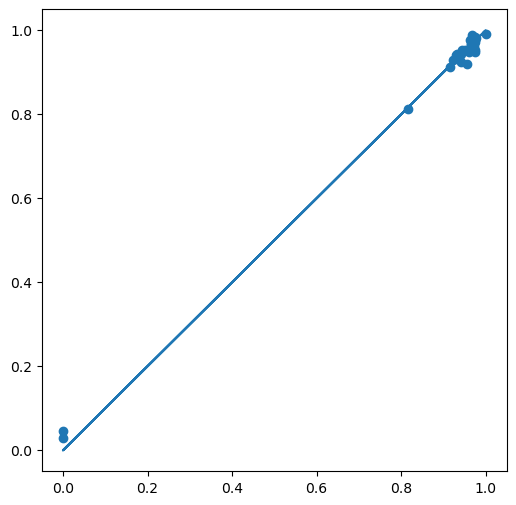

In [29]:
fig, ax = plt.subplots(figsize = (6,6))

ax.scatter(train_y, mean)
ax.plot(train_y, train_y)

(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 29.]),
 array([-1.86522430e-08,  9.99999805e-02,  1.99999980e-01,  2.99999979e-01,
         3.99999978e-01,  4.99999977e-01,  5.99999976e-01,  6.99999975e-01,
         7.99999974e-01,  8.99999974e-01,  9.99999973e-01]),
 <BarContainer object of 10 artists>)

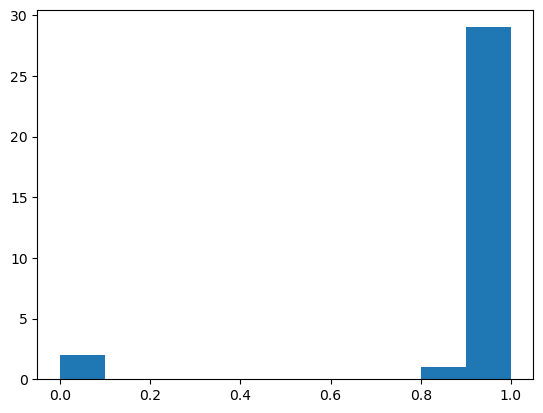

In [30]:
plt.hist(train_y)

In [31]:
t_start = time.time()
# fit the models

fit_gpytorch_mll(mll_nei)

# define the qEI and qNEI acquisition modules using a QMC sampler
qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

# for best_f, we use the best observed noisy values as an approximation


qLogNEI = qLogNoisyExpectedImprovement(
    model=model_nei,
    X_baseline=train_x,
    sampler=qmc_sampler,
    objective=objective,
    prune_baseline=True
)

#ucb = qUpperConfidenceBound(
#    model = model_nei, 
##    beta = 5,
#    sampler = qmc_sampler, 
#)

# optimize for new candidates
candidates, _ = optimize_acqf(
    acq_function=qLogNEI,
    bounds=bounds_torch_opt,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    #options={"batch_limit": 5, "maxiter": 200},
)

print(f'Optimized acqf in {time.time() - t_start} s')

Optimized acqf in 17.847184896469116 s


In [32]:
train_x.max()

tensor(0.9916, dtype=torch.float64)

## Visualize model predictions

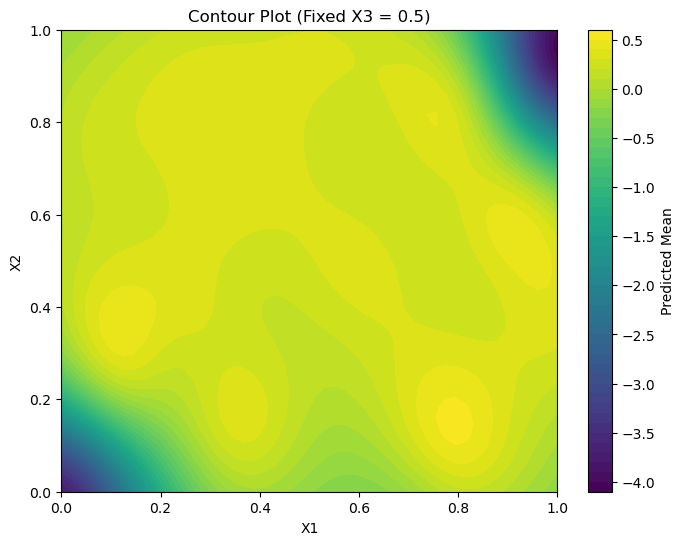

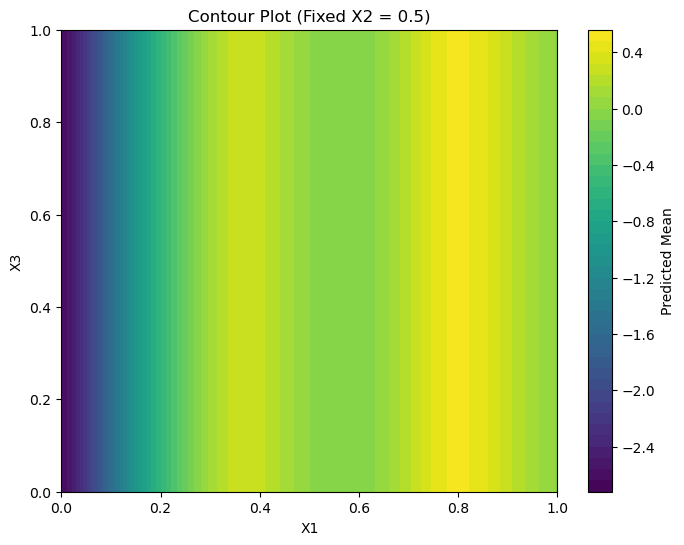

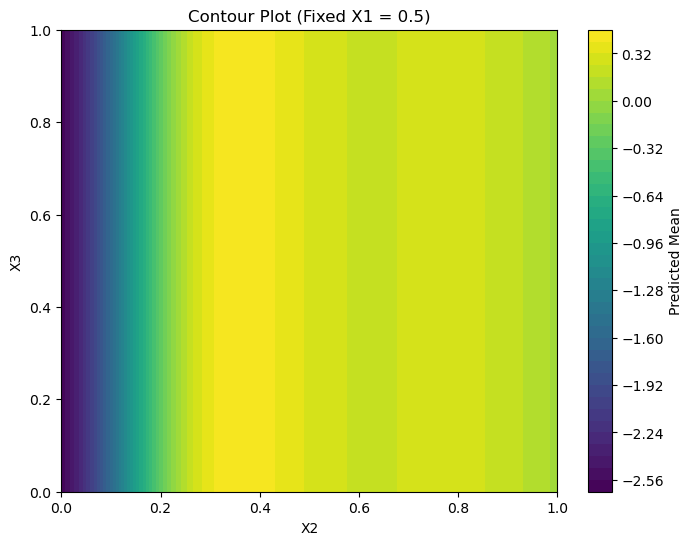

In [33]:
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots
def plot_contour_fixed_dimension(model, fixed_dim, fixed_val, x_range, y_range, dim_labels, title):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict with the model
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        mean = preds.mean.numpy().reshape(X.shape)  # Reshape to match grid

    # Plot the contour
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, mean, levels=50, cmap="viridis")
    plt.colorbar(cp, label="Predicted Mean")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices by fixing each dimension at a particular value
fixed_vals = [0.1, 0.1, 0.1]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=2, fixed_val=fixed_vals[2], 
                             x_range=x, y_range=y, 
                             dim_labels=["X1", "X2"], 
                             title="Contour Plot (Fixed X3 = 0.5)")


# Slice along X1 and X3, fixing X2 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=1, fixed_val=fixed_vals[1], 
                             x_range=x, y_range=z, 
                             dim_labels=["X1", "X3"], 
                             title="Contour Plot (Fixed X2 = 0.5)")

# Slice along X2 and X3, fixing X1 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=0, fixed_val=fixed_vals[0], 
                             x_range=y, y_range=z, 
                             dim_labels=["X2", "X3"], 
                             title="Contour Plot (Fixed X1 = 0.5)")


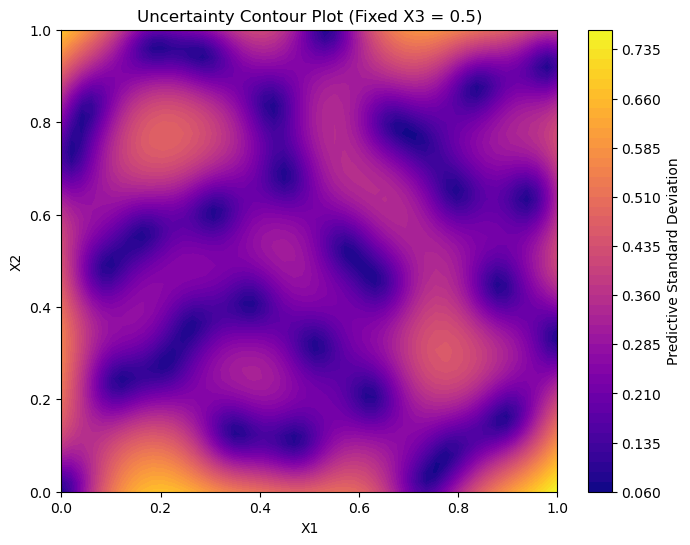

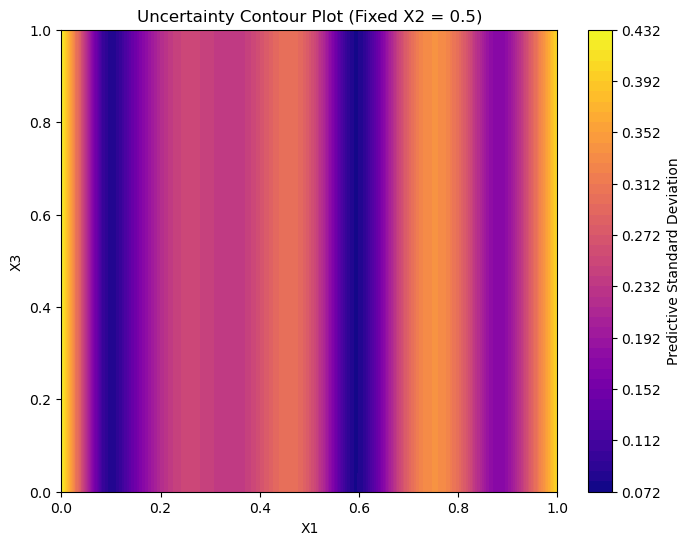

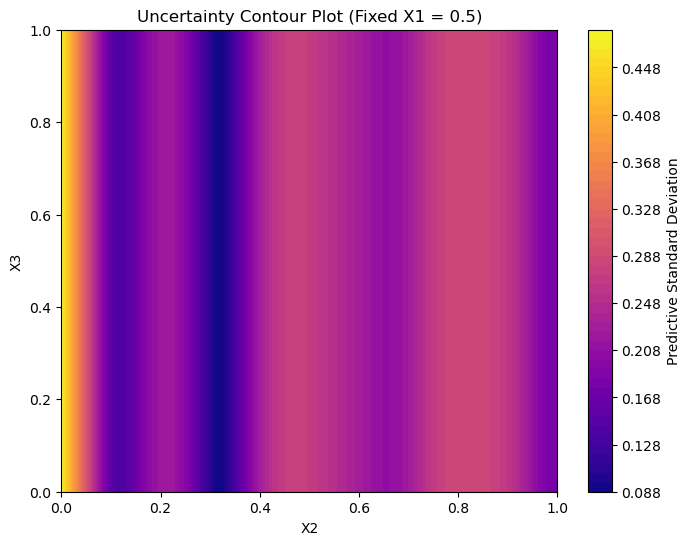

In [34]:
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots for uncertainty
def plot_contour_uncertainty(model, fixed_dim, fixed_val, x_range, y_range, dim_labels, title):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict with the model to get uncertainty (standard deviation)
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        std_dev = preds.variance.sqrt().numpy().reshape(X.shape)  # Reshape to match grid

    # Plot the contour of uncertainty
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, std_dev, levels=50, cmap="plasma")  # Plasma color map for uncertainty
    plt.colorbar(cp, label="Predictive Standard Deviation")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices of uncertainty by fixing each dimension at a particular value
fixed_vals = [0.5, 0.5, 0.5]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=2, fixed_val=fixed_vals[2], 
                         x_range=x, y_range=y, 
                         dim_labels=["X1", "X2"], 
                         title="Uncertainty Contour Plot (Fixed X3 = 0.5)")

# Slice along X1 and X3, fixing X2 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=1, fixed_val=fixed_vals[1], 
                         x_range=x, y_range=z, 
                         dim_labels=["X1", "X3"], 
                         title="Uncertainty Contour Plot (Fixed X2 = 0.5)")

# Slice along X2 and X3, fixing X1 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=0, fixed_val=fixed_vals[0], 
                         x_range=y, y_range=z, 
                         dim_labels=["X2", "X3"], 
                         title="Uncertainty Contour Plot (Fixed X1 = 0.5)")

## ACQ func value

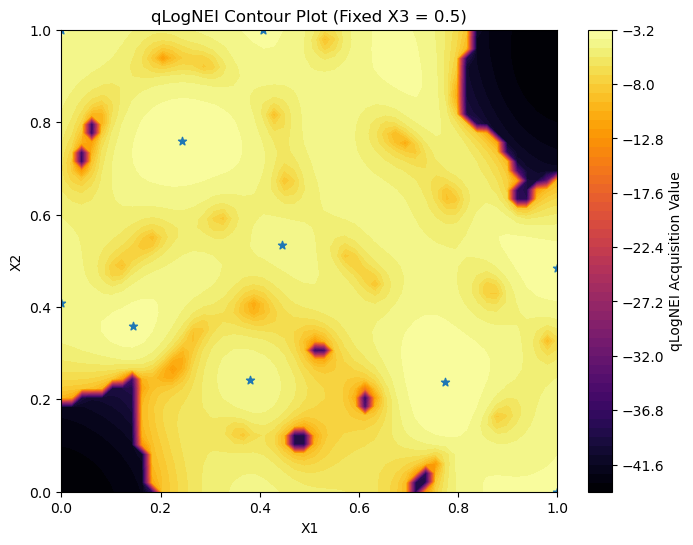

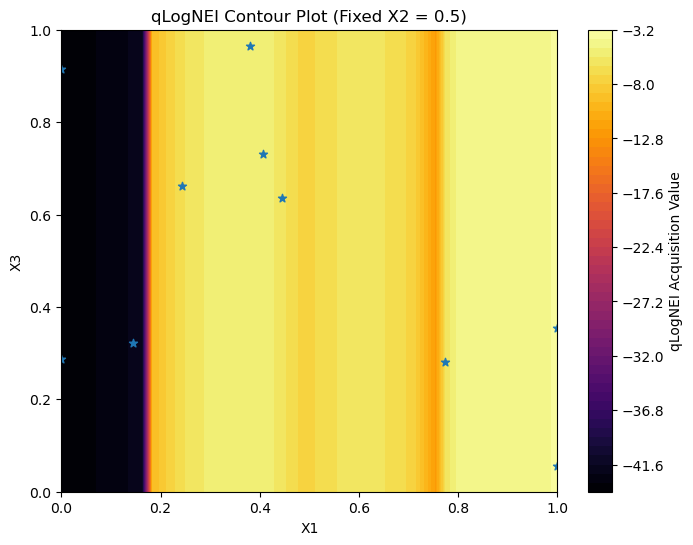

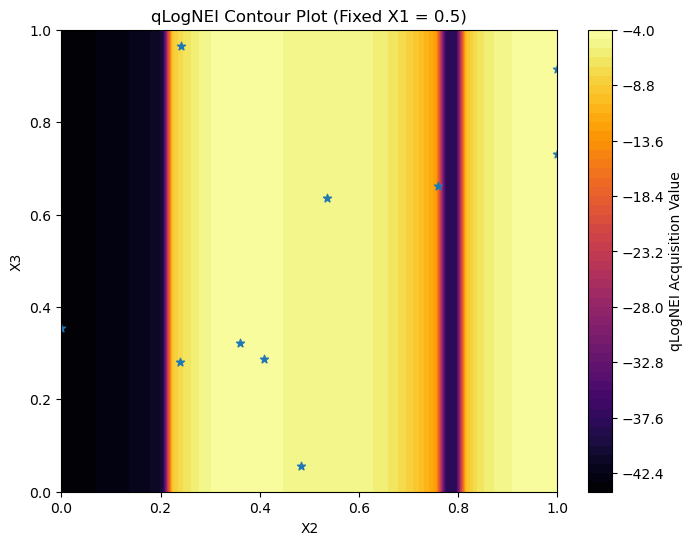

In [35]:
acq_func = qLogNEI
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots for qLogNoisyExpectedImprovement
def plot_qlognei_contour(acq_func, fixed_dim, fixed_val, x_range, y_range, dim_labels, title, candidates = candidates):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Compute qLogNoisyExpectedImprovement values at each grid point individually
    acq_func_values = []
    for i in range(grid_tensor.shape[0]):
        point = grid_tensor[i].unsqueeze(0)  # Make it a batch of 1
        acq_value = acq_func(point).item()  # Evaluate and get scalar value
        acq_func_values.append(acq_value)

    acq_func_values = np.array(acq_func_values).reshape(X.shape)  # Reshape to match grid

    dims = [0,1,2]
    dims.remove(fixed_dim)
    # Plot the contour of qLogNoisyExpectedImprovement
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, acq_func_values, levels=50, cmap="inferno")  # Inferno color map for acquisition function
    plt.scatter(candidates[:,dims[0]], candidates[:,dims[1]], marker = '*')
    plt.colorbar(cp, label="qLogNEI Acquisition Value")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices of qLogNEI by fixing each dimension at a particular value
fixed_vals = [0.06, 0.06, 0.06]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=2, fixed_val=fixed_vals[2], 
                     x_range=x, y_range=y, 
                     dim_labels=["X1", "X2"], 
                     title="qLogNEI Contour Plot (Fixed X3 = 0.5)", candidates =  candidates)

# Slice along X1 and X3, fixing X2 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=1, fixed_val=fixed_vals[1], 
                     x_range=x, y_range=z, 
                     dim_labels=["X1", "X3"], 
                     title="qLogNEI Contour Plot (Fixed X2 = 0.5)", candidates = candidates)

# Slice along X2 and X3, fixing X1 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=0, fixed_val=fixed_vals[0], 
                     x_range=y, y_range=z, 
                     dim_labels=["X2", "X3"], 
                     title="qLogNEI Contour Plot (Fixed X1 = 0.5)", candidates = candidates)


## Visualize new batch

In [36]:
tsne = TSNE()

In [37]:
x_data_norm.shape

torch.Size([32, 3])

In [38]:
all_x = torch.cat([x_data_norm, candidates])

In [39]:
x_tsne_og = tsne.fit_transform(all_x)

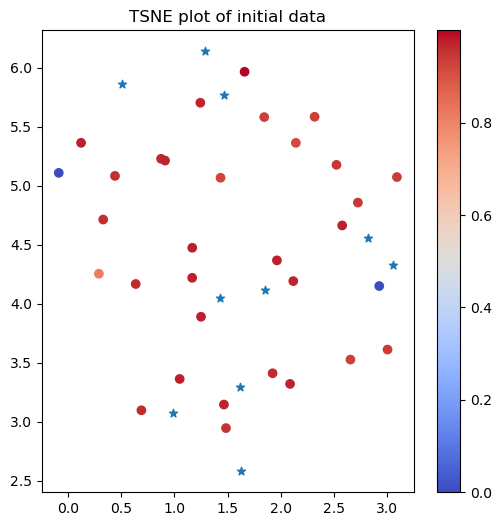

In [40]:
fig, ax = plt.subplots(figsize = (6,6))

sc = ax.scatter(x_tsne_og[:,0][:len(x_data_norm)], x_tsne_og[:,1][:len(x_data_norm)], c = train_y, cmap = plt.cm.coolwarm)
ax.scatter(x_tsne_og[:,0][len(x_data_norm):], x_tsne_og[:,1][len(x_data_norm):], marker='*')
ax.set_title("TSNE plot of initial data")
fig.colorbar(sc, ax = ax)

## Prep new sample table for next experiment

In [41]:
x_fractions = unnormalize(candidates, bounds_torch_norm)

In [43]:
target_volume = 1700
target_dilution = 0.1 # mol Si/L saxs sample
constants_fp = './constants_Round2_2025_01_28.json'
samples_write_fp = 'Sample_table_2025_01_28_80nmRound1_rmse.csv'


In [44]:
samples_gen = []
for row in x_fractions:
    teos_vf = float(row[0])
    ammonia_vf = float(row[1])
    water_vf = float(row[2])

    sample = samples.SolidSilicaSample(target_volume, teos_vol_frac = teos_vf, ammonia_vol_frac=ammonia_vf, water_vol_frac=water_vf, reactant_fp = constants_fp)
    sample.calculate_reactant_volumes()
    sample.calculate_dilution_volumefraction(target_dilution)
    sample.calculate_silica_mass_concentration()
    sample.calculate_silica_mass_fraction()
    samples_gen.append(sample)

344.62171575054526
629.6163549833
762.7671613590792
507.91033102665097
648.0064222961664
477.43667896836996
300.73948584962636
801.2166175805032
672.8991015814245
515.8322999952361


In [45]:
synth_table = samples.generate_synthesis_table(samples_gen)

In [46]:
synth_table['ethanol_dilute_vol'] = np.round(target_volume*(1-synth_table['dilution_volume_fraction']))
synth_table['sample_dilute_vol'] = np.round(target_volume * synth_table['dilution_volume_fraction'])

In [47]:
synth_table.loc[synth_table['ethanol_dilute_vol'] < 0, 'ethanol_dilute_vol'] = 0
synth_table.loc[synth_table['sample_dilute_vol'] > target_volume, 'sample_dilute_vol'] = target_volume

In [48]:
#assign rows to sample table
rows = ['A', 'B', 'C', 'D', 'E', 'F']
cols = [1, 2, 3, 4, 5, 6, 7, 8]

wells = []

#skip [B,E]x[2,7]
for row in rows:
    for col in cols:
        if row in ['B', 'E'] and col in [2, 7]:
            pass
        else:
            wells.append(row + str(col))

In [49]:
synth_table['well'] = wells[len(synth_table):2*len(synth_table)]


In [50]:
synth_table['dilute_well'] = wells[3*len(synth_table):4*len(synth_table)]

## Visualize new batch

In [51]:
synth_data['rank'] = synth_data['ap_distance'].rank()

In [52]:
best_row = synth_data.iloc[synth_data['ap_distance'].argmin()]

In [53]:
best10 = synth_data.iloc[synth_data['rank'].argsort().iloc[:10]]

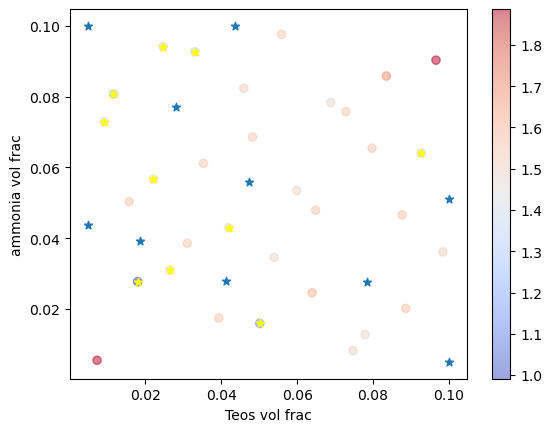

In [54]:
fig, ax = plt.subplots()

sc = ax.scatter(synth_data['teos_vol_frac'], synth_data['ammonia_vol_frac'], c = synth_data['ap_distance'], cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac')
ax.set_ylabel('ammonia vol frac')


ax.scatter(best10['teos_vol_frac'], best10['ammonia_vol_frac'], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

ax.scatter(synth_table['teos_volume']/target_volume/synth_constants['TEOS']['dilution_ratio'], synth_table['ammonia_volume']/target_volume/synth_constants['ammonia']['dilution_ratio'], marker = '*')

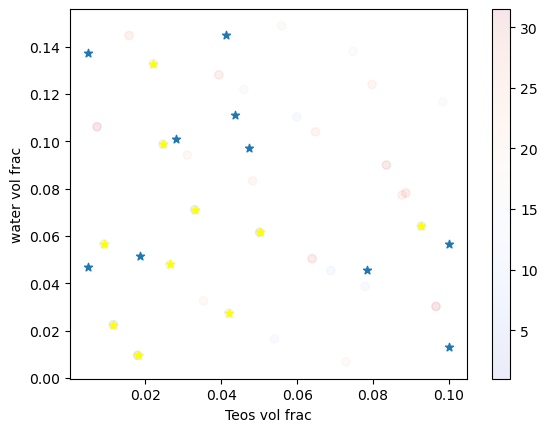

In [55]:
fig, ax = plt.subplots()

sc = ax.scatter(synth_data['teos_vol_frac'], synth_data['water_vol_frac'], c = synth_data['rank'], cmap = plt.cm.coolwarm, alpha=0.1)
ax.set_xlabel('Teos vol frac')
ax.set_ylabel('water vol frac')
cbar = fig.colorbar(sc, ax = ax)

ax.scatter(best10['teos_vol_frac'], best10['water_vol_frac'], marker = '*', color = 'yellow')

ax.scatter(synth_table['teos_volume']/target_volume/synth_constants['TEOS']['dilution_ratio'], synth_table['water_volume']/target_volume/synth_constants['water']['dilution_ratio'], marker = '*')

In [56]:
synth_table

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,ethanol_dilute_vol,sample_dilute_vol,well,dilute_well
0,9cff952d-2d28-47b2-bb0b-d49602fd36d2,90.614116,189.664150,250.625458,1169.096276,1.193493,5.033963,0.006237,0.0,1700.0,B4,E1
1,60e54cc2-4d8e-4d0e-aab8-390bef44dcf8,228.684063,270.377199,470.888258,730.050480,0.472911,12.704280,0.015444,896.0,804.0,B5,E3
2,bde1a208-9fee-499e-843b-7866aa600a77,24.224999,484.500007,666.348728,524.926265,4.464286,1.345792,0.001622,0.0,1700.0,B6,E4
3,8f8ed9a5-2ea3-440f-93bf-01d9f6cbc33d,484.500007,24.224999,273.731449,917.543544,0.223214,26.915840,0.032983,1321.0,379.0,B8,E5
4,f93ed4f1-94fb-4806-835e-4975da39c452,135.707419,373.352663,489.220082,701.719836,0.796915,7.539070,0.009161,345.0,1355.0,C1,E6
5,99049d8c-98af-4240-ad63-7784477d7c02,379.921139,133.905259,221.684161,964.489441,0.284657,21.106082,0.025954,1216.0,484.0,C2,E8
6,a35e929b-49fd-4bed-a211-70524348fe8e,24.224999,212.324890,226.751481,1236.698630,4.464286,1.345792,0.001673,0.0,1700.0,C3,F1
7,069a5c5d-4bfd-419e-a96e-36215855466d,211.666209,484.500007,538.140465,465.693319,0.510933,11.758873,0.014169,831.0,869.0,C4,F2
8,627048de-ccfc-4b9e-998f-c83de2ac353f,199.575596,135.113642,701.939108,663.371654,0.541887,11.087193,0.013380,779.0,921.0,C5,F3
9,9f8223fc-c3be-4ca7-b9c9-55fa9c4daa60,484.500007,246.977225,63.183338,905.339430,0.223214,26.915840,0.033145,1321.0,379.0,C6,F4


In [57]:
synth_table.to_csv(samples_write_fp)